In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c state-farm-distracted-driver-detection

state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip /content/state-farm-distracted-driver-detection.zip

Archive:  /content/state-farm-distracted-driver-detection.zip
replace driver_imgs_list.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import Libraries

In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
from tensorflow.keras import layers
from keras import models 
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

#VIS
from keras.utils.vis_utils import plot_model

# Preprocessing Data

In [2]:
def preparData(path):
  imagsList = []
  labels = []
  for dic in sorted(glob.glob(os.path.join(path,'*')), key = lambda k: k.split('/')[-1]):
    for imgs in glob.glob(os.path.join(dic, '*.jpg')):
      img = cv2.imread(imgs)
      img_r = cv2.resize(img,(128,128))
      imagsList.append(img_r)
      labels.append(int(dic.split("/")[-1].replace('c','')))
  
  X_train, X_test, y_train, y_test = train_test_split(imagsList, labels, test_size=0.2,shuffle= True, random_state = 0)
  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return np.array(X_train), np.array(X_test), y_train, y_test


#Get Data

In [3]:
path_train = "/content/imgs/train/"
path_test  = "/content/imgs/test/"

X_train, X_test, y_train, y_test = preparData(path_train)

print(f"Size X_train: {len(X_train)}, Size y_train: {len(y_train)}")
print(f"Size X_test: {len(X_test)}, Size y_test {len(y_test)}")

Size X_train: 17939, Size y_train: 17939
Size X_test: 4485, Size y_test 4485


# Data Augmentation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, 
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split = 0.2,
      fill_mode='nearest')

train_datagen.fit(X_train)


# VGG16 Model

In [6]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (128, 128, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
conv_base.trainable = False
vgg_model_1 = models.Sequential()
vgg_model_1.add(conv_base)
vgg_model_1.add(layers.Flatten())
vgg_model_1.add(layers.Dense(units=512, activation='relu'))
vgg_model_1.add(layers.Dense(units=256, activation='relu'))
vgg_model_1.add(layers.Dense(units=256, activation='relu'))
vgg_model_1.add(layers.Dense(units=128, activation='relu'))
vgg_model_1.add(layers.Dense(units=64, activation='relu'))
vgg_model_1.add(layers.Dense(units=10,activation='softmax'))
vgg_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8

**Plot Model**

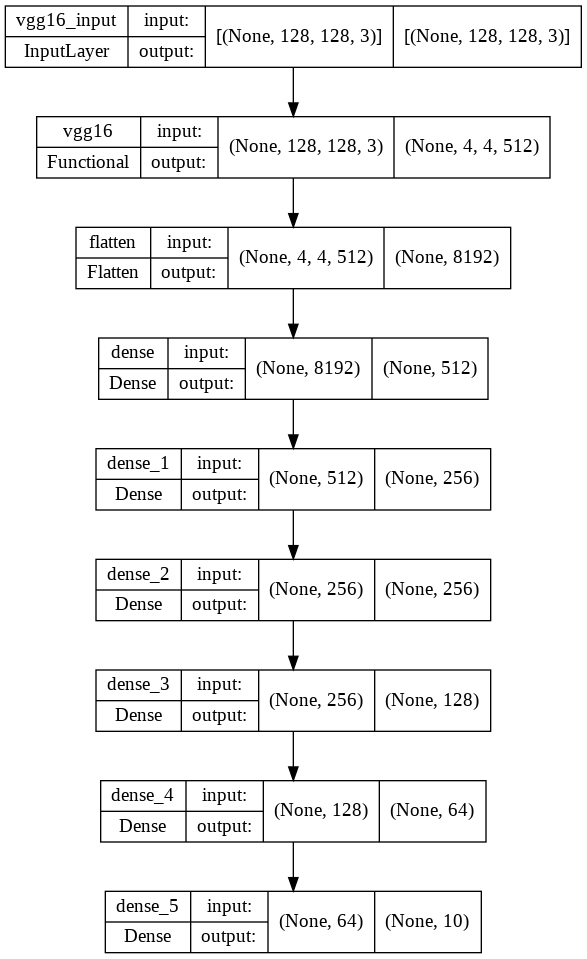

In [8]:
plot_model(vgg_model_1,show_shapes=True)

**Model Compile**

In [9]:
vgg_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Train Model**

In [10]:
vgg_history = vgg_model_1.fit(train_datagen.flow(X_train, y_train, batch_size=128,
         subset='training'),
         validation_data=train_datagen.flow(X_train, y_train, subset='validation'),
         steps_per_epoch=train_datagen.flow(X_train, y_train, batch_size=32,
         subset='training').n / 128, epochs=15)

Epoch 1/15
112/112 [==============================] - 85s 638ms/step - loss: 1.9954 - accuracy: 0.2614 - val_loss: 1.6376 - val_accuracy: 0.3936
Epoch 2/15
112/112 [==============================] - 70s 628ms/step - loss: 1.3243 - accuracy: 0.5201 - val_loss: 1.1534 - val_accuracy: 0.5916
Epoch 3/15
112/112 [==============================] - 70s 625ms/step - loss: 1.0383 - accuracy: 0.6375 - val_loss: 0.9389 - val_accuracy: 0.6755
Epoch 4/15
112/112 [==============================] - 70s 621ms/step - loss: 0.8816 - accuracy: 0.6974 - val_loss: 0.8501 - val_accuracy: 0.7087
Epoch 5/15
112/112 [==============================] - 70s 622ms/step - loss: 0.7925 - accuracy: 0.7308 - val_loss: 0.7149 - val_accuracy: 0.7533
Epoch 6/15
112/112 [==============================] - 70s 624ms/step - loss: 0.7181 - accuracy: 0.7526 - val_loss: 0.7557 - val_accuracy: 0.7441
Epoch 7/15
112/112 [==============================] - 70s 623ms/step - loss: 0.6687 - accuracy: 0.7684 - val_loss: 0.6349 - val_ac

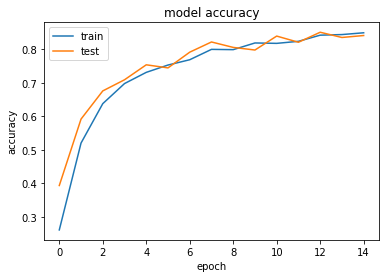

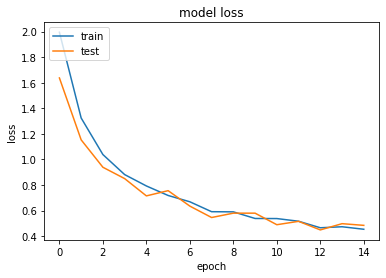

In [11]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Save Model

In [ ]:
vgg_model_1.save('model_online_feature.h5')